<a href="https://colab.research.google.com/github/garthajon/QuantFinanceIntro/blob/main/ZSCORE_WEEKLY_WITH_GARCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install arch




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 18.6 MB/s eta 0:00:00


/tmp/ipython-input-1970567780.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']



TSLA - GARCH Weekly Forecast (Z-scores, 2 weeks):
[0.00265844 0.0252686 ]


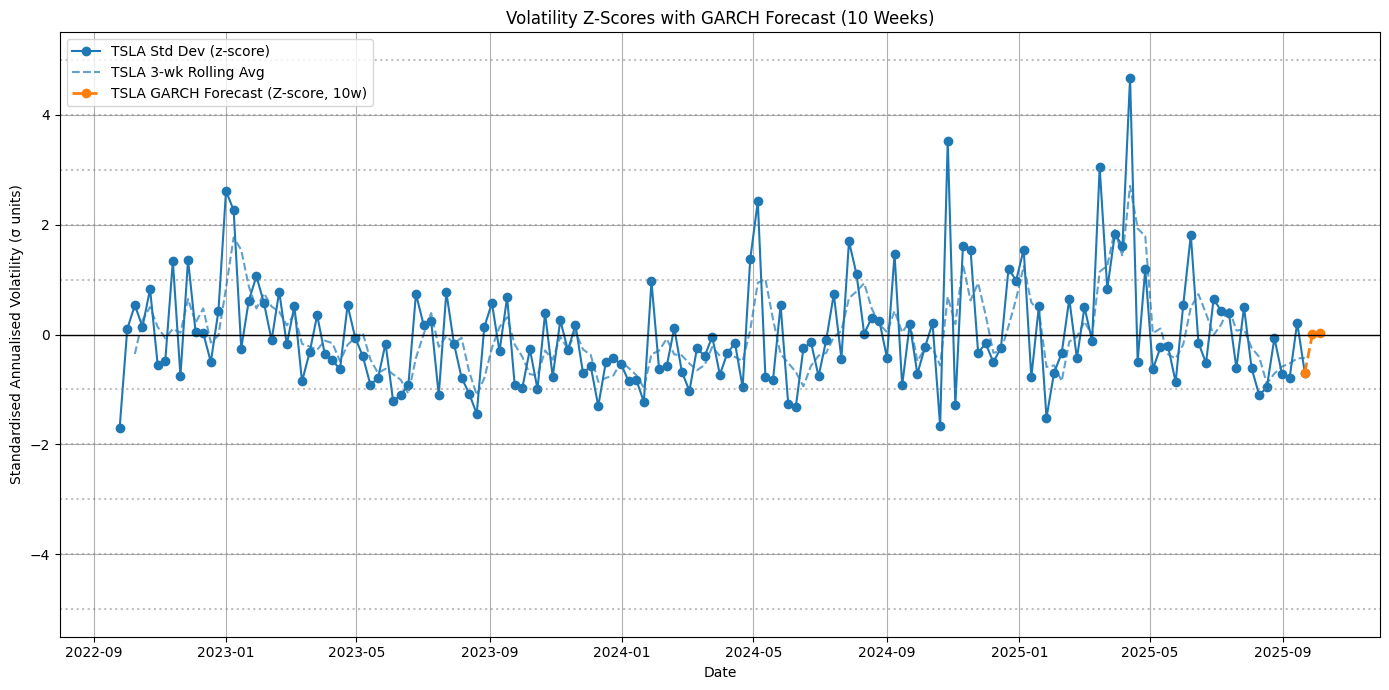

In [18]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model

# -----------------------------
# Parameters
# -----------------------------
tickers = ['TSLA']
end_date = pd.Timestamp.today()
start_date = end_date - pd.DateOffset(years=3)  # 5 years of data

# -----------------------------
# Fetch daily data
# -----------------------------
df = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']
returns = df.pct_change().dropna()  # returns in decimal (e.g. 0.01 = 1%)

# -----------------------------
# Weekly realised volatility (annualised) → z-score
# -----------------------------
weekly_std = returns.resample('W').std() * np.sqrt(252)
standardised = pd.DataFrame(index=weekly_std.index)

zscore_params = {}
for ticker in tickers:
    mu = weekly_std[ticker].mean()
    sigma = weekly_std[ticker].std(ddof=0)
    standardised[ticker] = (weekly_std[ticker] - mu) / sigma
    zscore_params[ticker] = (mu, sigma)

rolling_avg3 = standardised.rolling(window=3, min_periods=3).mean()

# -----------------------------
# GARCH Forecast → weekly z-score
# -----------------------------
garch_forecasts = {}
n_weeks = 2
trading_days_per_week = 5
horizon_days = n_weeks * trading_days_per_week  # 10 trading days

for ticker in tickers:
    # Fit GARCH(1,1) on returns * 100 (percent)
    am = arch_model(returns[ticker] * 100, vol='Garch', p=1, q=1)
    res = am.fit(disp="off")

    # Forecast next horizon_days daily variances (percent^2)
    forecast = res.forecast(horizon=horizon_days, reindex=False)
    daily_var_percent2 = forecast.variance.values[-1, :]
    daily_vol_percent = np.sqrt(daily_var_percent2)

    # Convert percent → decimal
    daily_vol_decimal = daily_vol_percent / 100.0

    # Aggregate into weekly annualised vols
    weekly_annualised = []
    for w in range(n_weeks):
        start = w * trading_days_per_week
        end = start + trading_days_per_week
        slice_daily = daily_vol_decimal[start:end]
        if len(slice_daily) == 0:
            break
        week_vol = np.sqrt(np.mean(slice_daily ** 2)) * np.sqrt(252)
        weekly_annualised.append(week_vol)
    weekly_annualised = np.array(weekly_annualised)

    # Convert to z-scores
    mu, sigma = zscore_params[ticker]
    weekly_z = (weekly_annualised - mu) / sigma

    garch_forecasts[ticker] = weekly_z

    print(f"\n{ticker} - GARCH Weekly Forecast (Z-scores, 2 weeks):")
    print(weekly_z)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(14,7))
colors = plt.cm.tab10.colors

for i, ticker in enumerate(tickers):
    # Historical z-scores
    plt.plot(standardised.index, standardised[ticker], marker='o',
             color=colors[i], label=f'{ticker} Std Dev (z-score)')

    # Rolling avg
    plt.plot(rolling_avg3.index, rolling_avg3[ticker], linestyle='--',
             color=colors[i], alpha=0.7, label=f'{ticker} 3-wk Rolling Avg')

    # Forecast index: weeks ahead
    last_date = standardised.index[-1]
    forecast_index = pd.date_range(last_date, periods=len(garch_forecasts[ticker])+1, freq='W')

    # Build forecast series that starts at last actual point
    last_actual = standardised[ticker].iloc[-1]
    forecast_series = np.concatenate([[last_actual], garch_forecasts[ticker]])

    plt.plot(forecast_index, forecast_series, linestyle="--",
             color=colors[(i+1) % len(colors)], linewidth=2, marker='o',
             label=f"{ticker} GARCH Forecast (Z-score, 10w)")

# Reference lines
plt.axhline(0, color='black', linestyle='-', linewidth=1)
for k in range(1,6):
    plt.axhline(k, color='grey', linestyle=':', alpha=0.5)
    plt.axhline(-k, color='grey', linestyle=':', alpha=0.5)

plt.title('Volatility Z-Scores with GARCH Forecast (10 Weeks)')
plt.xlabel('Date')
plt.ylabel('Standardised Annualised Volatility (σ units)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
